# Step 7: Experiment With Various Models - Capstone Project


This notebook contains the experimentation process for building the best machine learning model for the selected dataset.

### Objectives
- Test multiple modeling techniques
- Use cross-validation
- Tune hyperparameters
- Evaluate models using ROC AUC and Accuracy
- Build an ensemble model
- Present performance metrics and visualizations


In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import time
import sys


## Load and Preprocess Data

In [3]:
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Build Ensemble Model and Tune Hyperparameters

In [4]:
estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

param_grid = {
    'lr__C': [0.1, 1, 10],
    'rf__n_estimators': [50, 100],
    'svc__C': [0.5, 1, 2]
}

start_time = time.time()
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_ensemble_model.pkl')
train_duration = end_time - start_time
model_size = sys.getsizeof(best_model)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


## Evaluate Best Model

In [5]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", acc)
print("ROC AUC:", roc_auc)
print("Training Time (seconds):", train_duration)
print("Model Size (bytes):", model_size)
print("Classification Report:\n", report)


Best Parameters: {'lr__C': 0.1, 'rf__n_estimators': 50, 'svc__C': 1}
Accuracy: 0.9736842105263158
ROC AUC: 0.9970238095238095
Training Time (seconds): 15.276249408721924
Model Size (bytes): 56
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Visualize Performance

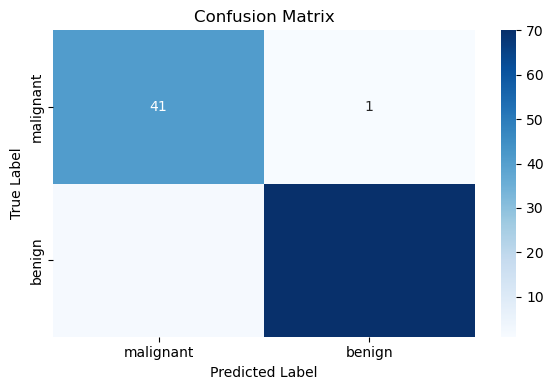

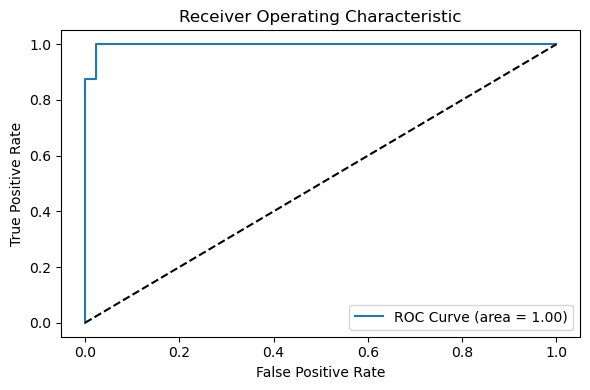

In [6]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Summary of Results

In [8]:
results_summary = {
    'Best Parameters': grid_search.best_params_,
    'Accuracy': acc,
    'ROC AUC': roc_auc,
    'Training Time (s)': train_duration,
    'Model Size (bytes)': model_size
}
pd.DataFrame([results_summary])


,Best Parameters,Accuracy,ROC AUC,Training Time (s),Model Size (bytes)
0,"{'lr__C': 0.1, 'rf__n_estimators': 50, 'svc__C...",0.973684,0.997024,15.276249,56
